What can we learn about different hosts and areas?
What can we learn from predictions? (ex: locations, prices, reviews, etc)
Which hosts are the busiest and why?
Is there any noticeable difference of traffic among different areas and what could be the reason for it?

What factors would make an Airbnb location have the highest chance to be chosen and reviewed to be able to be the most profitable for location.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import re
from string import punctuation
import matplotlib.patches as mpatches
import folium
from folium.plugins import MarkerCluster


#Load in data from csv
airbnb_df = pd.read_csv("../data/airbnb.csv")

#data cleaning dropping rows where no reviews are known
airbnb_df = airbnb_df.dropna(subset=["last_review", "reviews_per_month"])

#fill in null values of host_name and name
airbnb_df.fillna({"host_name": "Unknown", "name": "Unknown"}, inplace=True)

#rename name column to listing to better define
airbnb_df.rename(columns={"name": "listing"}, inplace=True)


#counting how many rows each neighborhood has
grp_by_neighborhood_counts = airbnb_df.groupby("neighbourhood_group")["number_of_reviews"].count()
grp_by_neighborhood_counts



neighbourhood_group
Bronx              876
Brooklyn         16447
Manhattan        16632
Queens            4574
Staten Island      314
Name: number_of_reviews, dtype: int64

In [3]:
#max and min number of reviews by neighborhood
grp_by_neighborhood_max_reviews = airbnb_df.groupby("neighbourhood_group")["number_of_reviews"].max()
grp_by_neighborhood_min_reviews = airbnb_df.groupby("neighbourhood_group")["number_of_reviews"].min()
grp_by_neighborhood_max_reviews, grp_by_neighborhood_min_reviews

(neighbourhood_group
 Bronx            321
 Brooklyn         488
 Manhattan        607
 Queens           629
 Staten Island    333
 Name: number_of_reviews, dtype: int64,
 neighbourhood_group
 Bronx            1
 Brooklyn         1
 Manhattan        1
 Queens           1
 Staten Island    1
 Name: number_of_reviews, dtype: int64)

In [4]:

#Creating sub dfs based on the neighborhood group for better comparisons
bronx_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Bronx"]
brooklyn_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Brooklyn"]
manhattan_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Manhattan"]
queens_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Queens"]
staten_island_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Staten Island"]

In [5]:
#two methods to remove punctuation re more efficient
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '',text)

def also_remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in punctuation])

# method that finds top ten percent of reviews overall and per month
# aka top performers of reviews
def find_top_ten_percent(df):
    """ 
    Finds top 10 percent of airbnb host based on
    number_of_reviews, reviews_per_month

    Parameters
    ----------
    df: DataFrame of airbnb information
    
    Returns
    -------
    top_ten_month: DataFrame that has top performers in the top 10 percent 
    by number_of_reviews AND reviews_per_month
    """
    percentile_90_nor = df['number_of_reviews'].quantile(0.90)
    percentile_90_nor_m = df['reviews_per_month'].quantile(0.90)
    top_ten = df[df['number_of_reviews']> percentile_90_nor]
    top_ten_month = top_ten[top_ten['reviews_per_month'] > percentile_90_nor_m]
    return top_ten_month



def get_non_top_performers(df, top_performers_df):
    ids_in_top_performers_df = top_performers_df["id"]
    non_top_performers_df = df[~df['id'].isin(ids_in_top_performers_df)]
    return non_top_performers_df


#method that retrieves the top fifteen most used words in the listing
#after cleaning the data 
def get_top_fifteen_words(df):
    """ 
    Retrieves the top fifteen most common words (excluding stopwords)
    
    remove cases and punctuation from listing creating a new column in def
    called listing processed. Then take the listing processed column and 
    expands into a single column of strings. Then 


    Parameters
    ----------
    df: dataFrame of airbnb information

    Returns
    -------
    top_15_words: Series of the 15 most common words (index) and their count (values)

    """

    df.loc[:,"listing_processed"] = df["listing"].str.lower().apply(remove_punctuation)
    all_words = df["listing_processed"].str.split(expand=True).stack()
    #records the value_counts of each word
    word_counts = all_words.value_counts()
    word_counts = pd.DataFrame(word_counts).apply(remove_stop_words, axis=1)
    sorted_word_counts = word_counts.sort_values(ascending=False)
    top_15_words = sorted_word_counts.head(15)
    return top_15_words

def remove_stop_words(x):
    """ 
    Changes the count value to 0 if index is in stopwords
    to remove it from consideration as part of most common
    due to the words being conjunctions

    Parameters
    ----------
    x: a word(str) in the listing
    
    Returns
    -------
    0 if index is in stopwords
    x["count"] if index not in stopwords
    
    """
    stopwords = ["and", "in", "on", "the", "to", "by", "with", "near", "1", "2", "of", "from"]
    if x.name in stopwords:
        return 0
    else:
        return x["count"]



def get_top_performers_top_fifteen_words(df):
    """ 
    Combining the two methods of find top performers and top 15 words in listing

    Parameters
    ----------
    df: dataFrame of airbnb information
    
    Returns
    -------
    top_ten_df, top_fifteen_words: a tuple where first element is df of top performers
    and the second is a Series which has 15 most common words and their counts
    
    """
    top_ten_df = find_top_ten_percent(df)
    top_fifteen_words = get_top_fifteen_words(top_ten_df)
    return top_ten_df, top_fifteen_words
    
#retrieve top performers and there most common words for all neighborhood groups
top_performers_bronx, top_15_words_bronx = get_top_performers_top_fifteen_words(bronx_airbnb_df)
top_performers_brooklyn, top_15_words_brooklyn = get_top_performers_top_fifteen_words(brooklyn_airbnb_df)
top_performers_manhattan, top_15_words_manhattan = get_top_performers_top_fifteen_words(manhattan_airbnb_df)
top_performers_queens, top_15_words_queens = get_top_performers_top_fifteen_words(queens_airbnb_df)
top_performers_staten_island, top_15_words_staten_island = get_top_performers_top_fifteen_words(staten_island_airbnb_df)
top_performers_overall, top_15_words_overall = get_top_performers_top_fifteen_words(airbnb_df)

#retrieve non top performers for graphing purposes later
non_tp_bronx = get_non_top_performers(bronx_airbnb_df, top_performers_bronx)
non_tp_brooklyn = get_non_top_performers(brooklyn_airbnb_df, top_performers_brooklyn)
non_tp_manhattan = get_non_top_performers(manhattan_airbnb_df, top_performers_manhattan)
non_tp_queens = get_non_top_performers(queens_airbnb_df, top_performers_queens)
non_tp_staten_island = get_non_top_performers(staten_island_airbnb_df, top_performers_staten_island)
non_tp_overall = get_non_top_performers(airbnb_df, top_performers_overall)

all_top_fifteen_words = get_top_fifteen_words(airbnb_df)


In [ ]:
#Testing purposes
#stopwords = ["and", "in", "on", "the", "to"]
#top_10_words_bronx[top_10_words_bronx.index.isin(stopwords)] = 0


In [7]:
def make_bar_graph_word_counts(series, name_str):
    """ 
    Create bar graph of most common 15 words in the airbnb series


    Parameters
    ----------
    series: Series that has information about top 15 most common words
    name_str: name of the Title for the graph 
    
    """
    fig, axs = plt.subplots(figsize = (12,4))
    axs.barh(series.index, series.values, color = "lightblue", edgecolor = "black")
    axs.set_xlabel('Top 15 Words')
    axs.set_ylabel('Frequency')
    axs.set_title(f"Top 15 Most Common Words In Top Performers {name_str}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

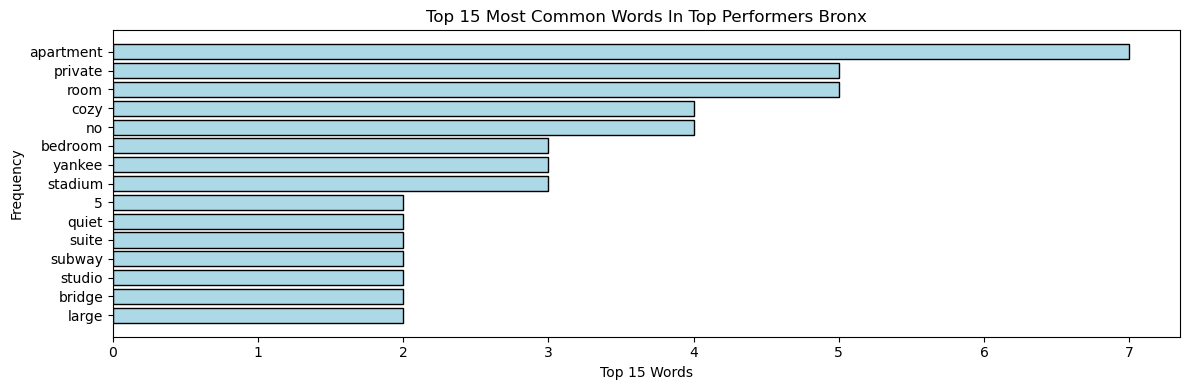

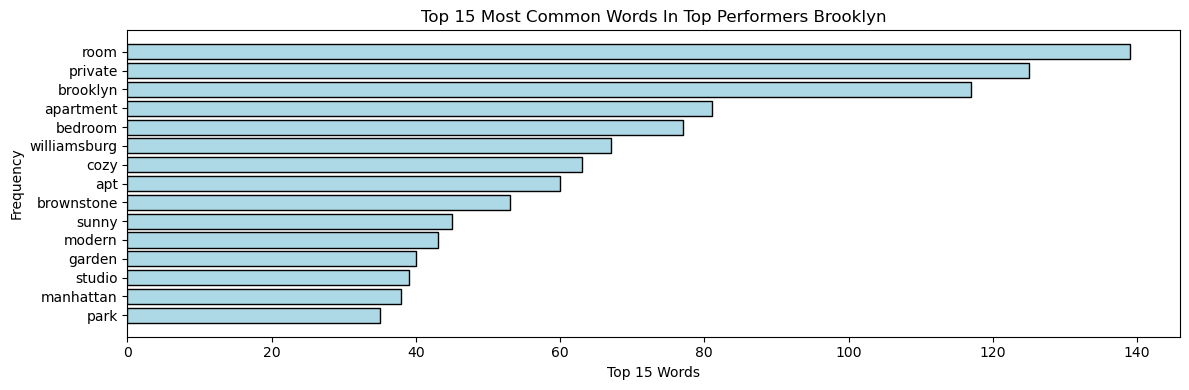

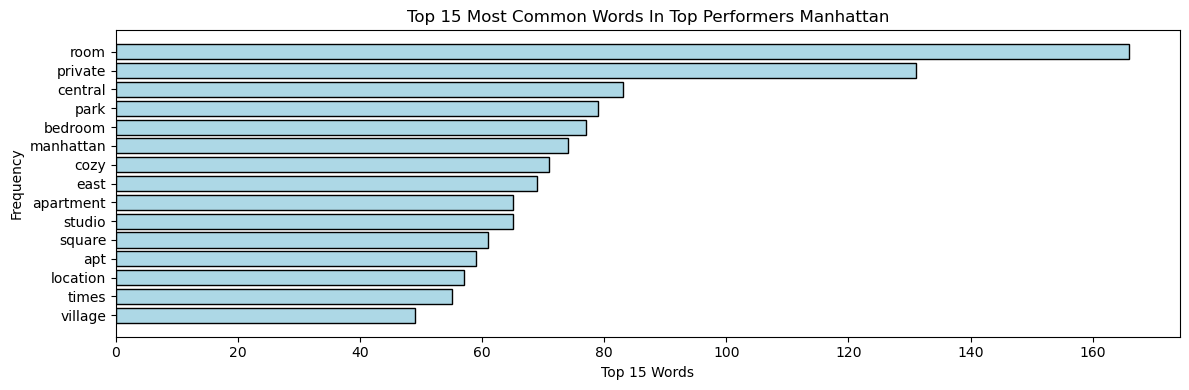

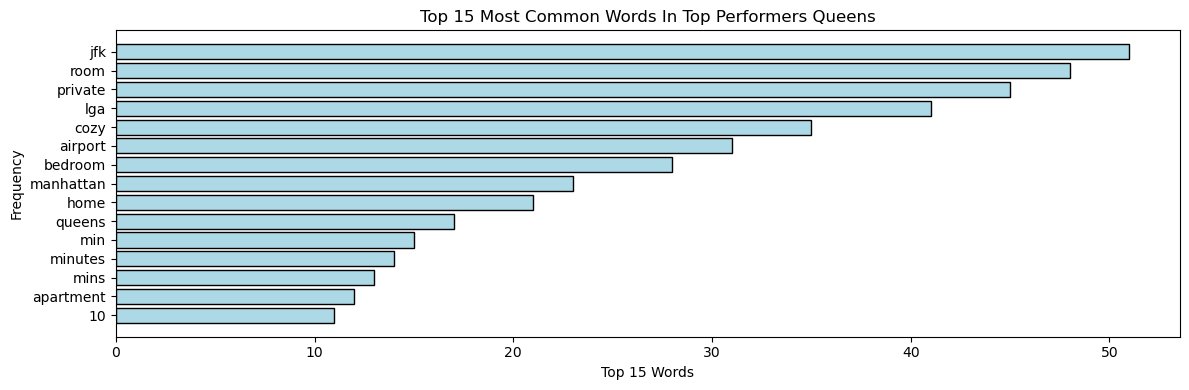

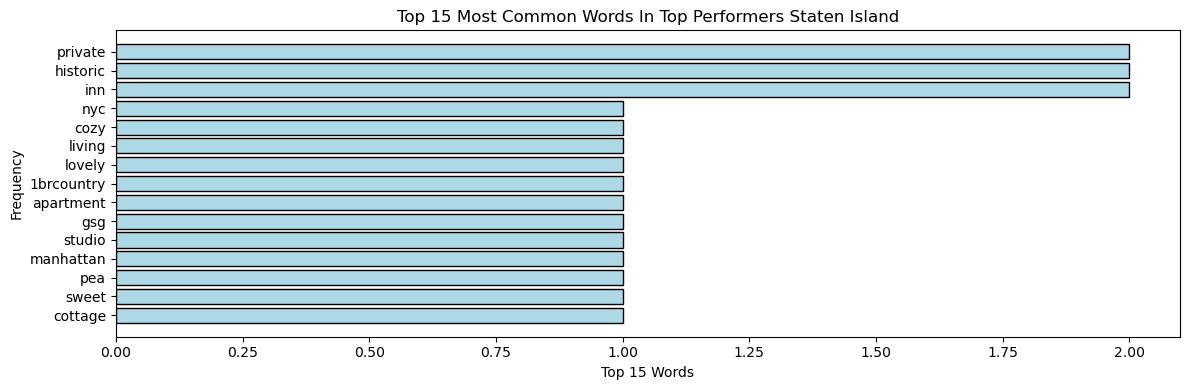

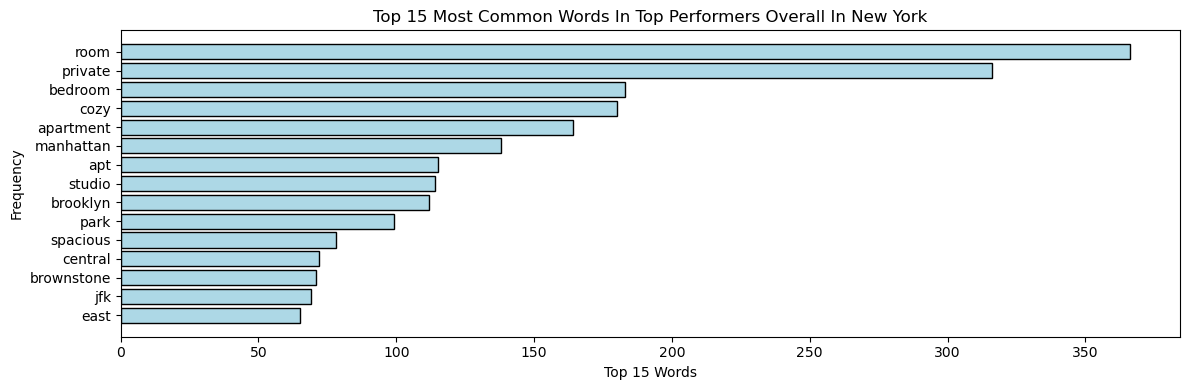

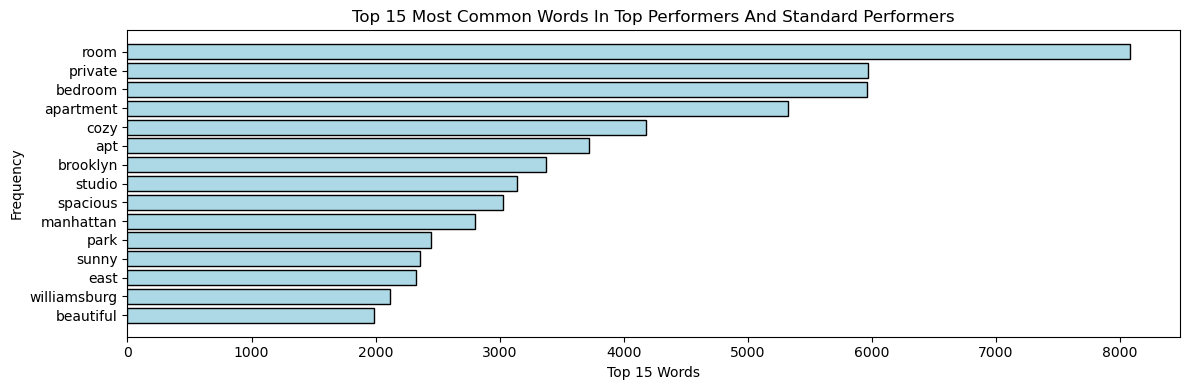

In [19]:
#Create the bar graphs for data
make_bar_graph_word_counts(top_15_words_bronx, "Bronx")
make_bar_graph_word_counts(top_15_words_brooklyn, "Brooklyn")
make_bar_graph_word_counts(top_15_words_manhattan, "Manhattan")
make_bar_graph_word_counts(top_15_words_queens, "Queens")
make_bar_graph_word_counts(top_15_words_staten_island, "Staten Island")
make_bar_graph_word_counts(top_15_words_overall, "Overall In New York")
make_bar_graph_word_counts(all_top_fifteen_words, "And Standard Performers")

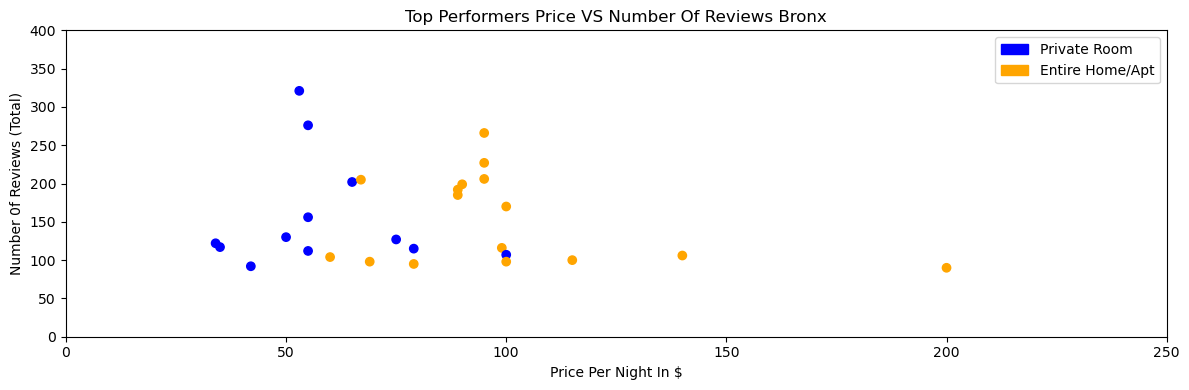

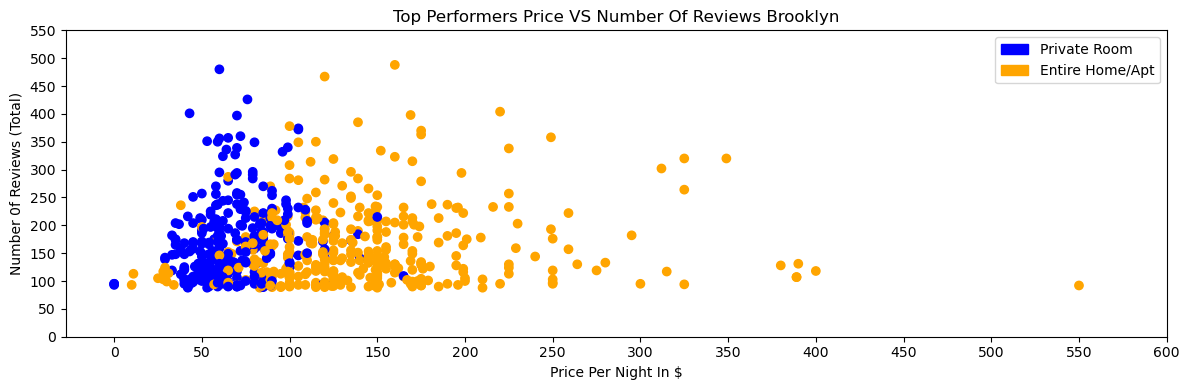

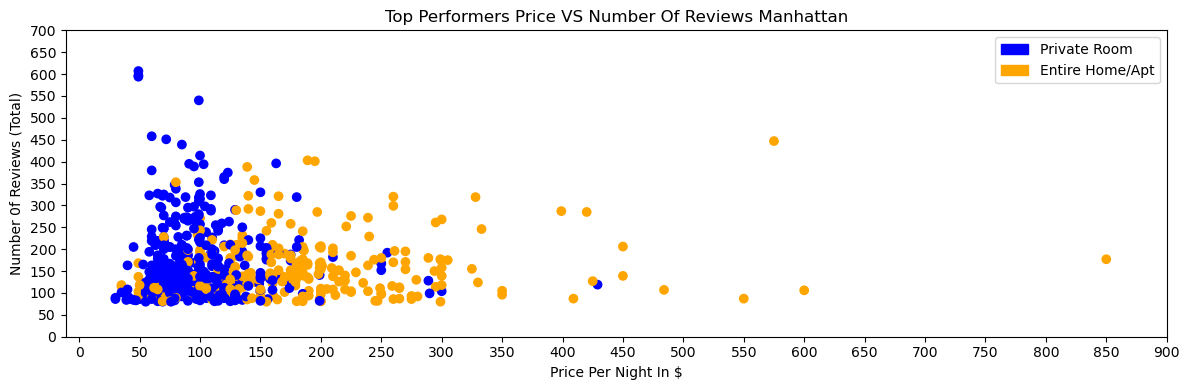

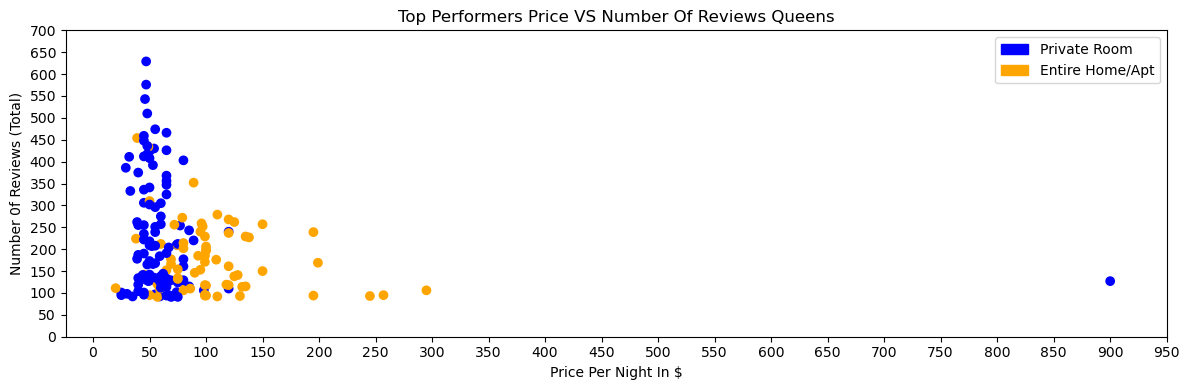

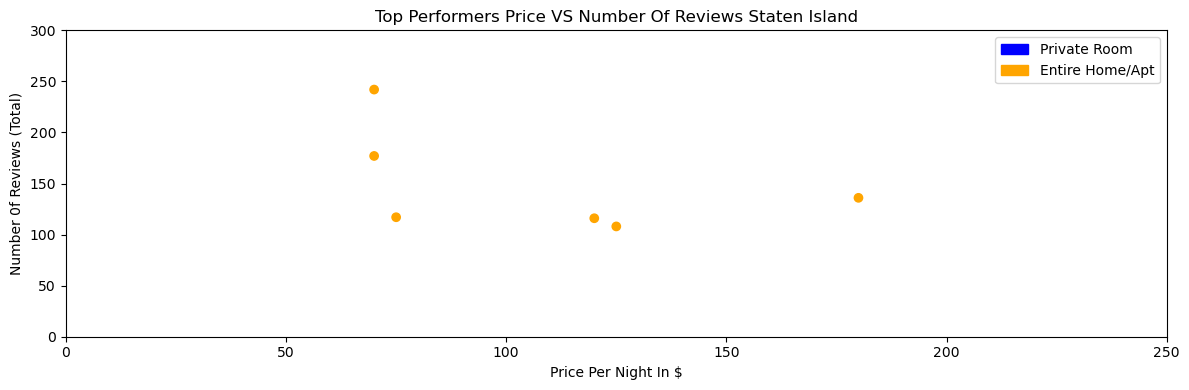

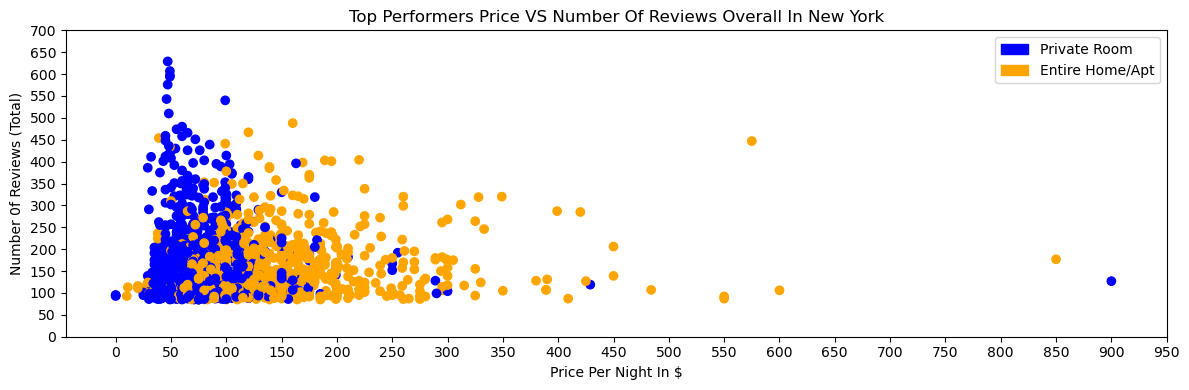

In [9]:
def make_scatter_reviews_price(df, name_str):
    #Seperate Colors based on room type
    color_array = np.where(df["room_type"] == "Private room", "blue", "orange")
    
    #Create multiple legend bars that correspond to the colors of the bar
    blue_patch = mpatches.Patch(color='blue', label='Private Room')
    orange_patch = mpatches.Patch(color='orange', label='Entire Home/Apt')

    fig, axs = plt.subplots(figsize = (12,4))
    axs.scatter(df["price"], df["number_of_reviews"], color=color_array)
    axs.set_xlabel('Price Per Night In $')
    axs.set_ylabel('Number 0f Reviews (Total)')
    axs.set_xticks(range(0, df["price"].max()+100, 50))
    axs.set_yticks(range(0, df["number_of_reviews"].max()+100, 50))
    axs.set_title(f"Top Performers Price VS Number Of Reviews {name_str}")
    plt.legend(handles=[blue_patch, orange_patch])
    plt.tight_layout()
    plt.show()

make_scatter_reviews_price(top_performers_bronx, "Bronx")
make_scatter_reviews_price(top_performers_brooklyn, "Brooklyn")
make_scatter_reviews_price(top_performers_manhattan, "Manhattan")
make_scatter_reviews_price(top_performers_queens, "Queens")
make_scatter_reviews_price(top_performers_staten_island, "Staten Island")
make_scatter_reviews_price(top_performers_overall, "Overall In New York")



In [10]:
def combine_scatters_reviews_price(df, name_str):
    #Seperate Colors based on room type
    color_array = np.where(df["room_type"] == "Private room", "blue", "orange")
    
    #Create multiple legend bars that correspond to the colors of the bar
    blue_patch = mpatches.Patch(color='blue', label='Private Room')
    orange_patch = mpatches.Patch(color='orange', label='Entire Home/Apt')

    fig, axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].scatter(df["price"], df["number_of_reviews"], color=color_array)
    axs[0].set_xlabel('Price Per Night In $')
    axs[0].set_ylabel('Number 0f Reviews (Total)')
    axs[0].set_xticks(range(0, df["price"].max()+100, 50))
    axs[0].set_yticks(range(0, df["number_of_reviews"].max()+100, 50))
    axs[0].set_title(f"Top Performers Price VS Total Reviews {name_str}")
    axs[0].legend(handles=[blue_patch, orange_patch])

    axs[1].scatter(df["price"], df["reviews_per_month"], color=color_array)
    axs[1].set_xlabel('Price Per Night In $')
    axs[1].set_ylabel('Number 0f Monthly Reviews')
    axs[1].set_xticks(range(0, df["price"].max()+100, 50))
    axs[1].set_yticks(range(0, int(df["reviews_per_month"].max())+6, 3))
    axs[1].set_title(f"Top Performers Price VS Monthly Reviews {name_str}")
    axs[1].legend(handles=[blue_patch, orange_patch])
    plt.tight_layout()
    plt.show()

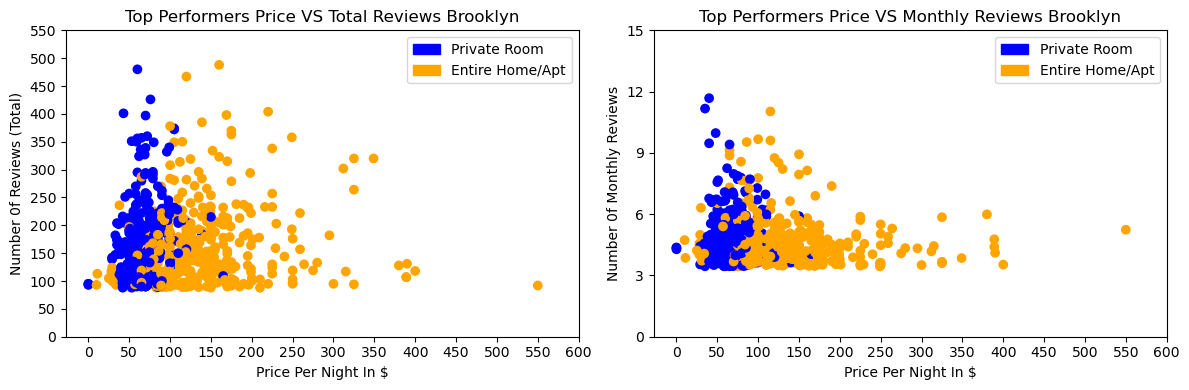

In [11]:
combine_scatters_reviews_price(top_performers_brooklyn, "Brooklyn")

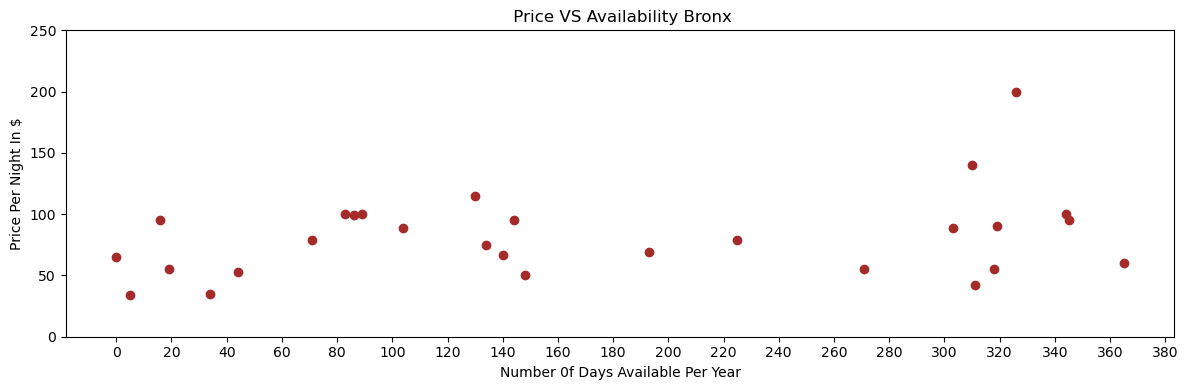

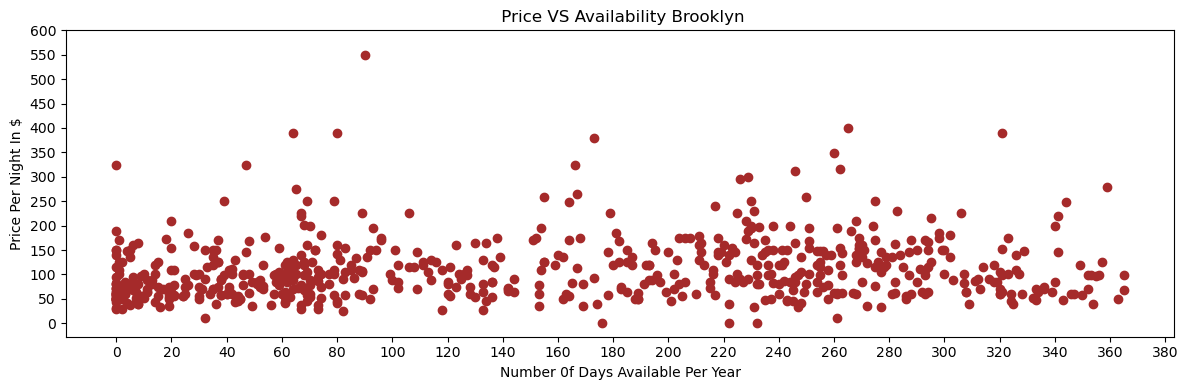

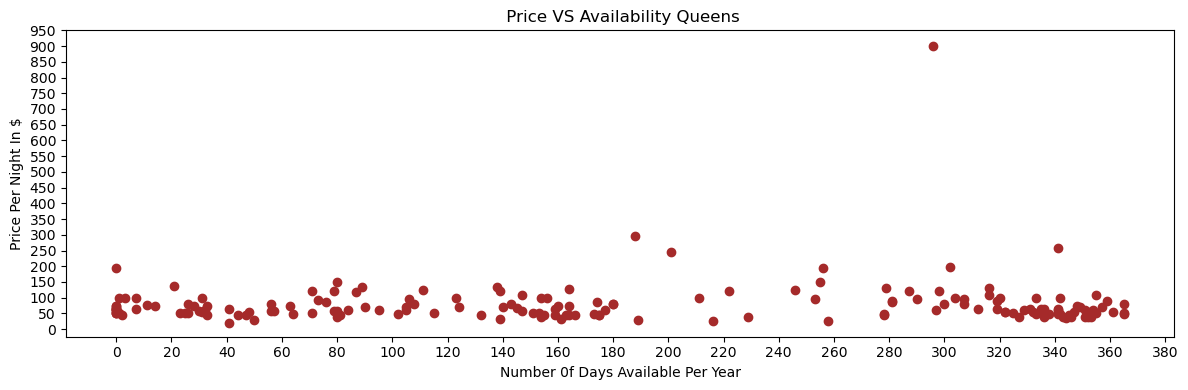

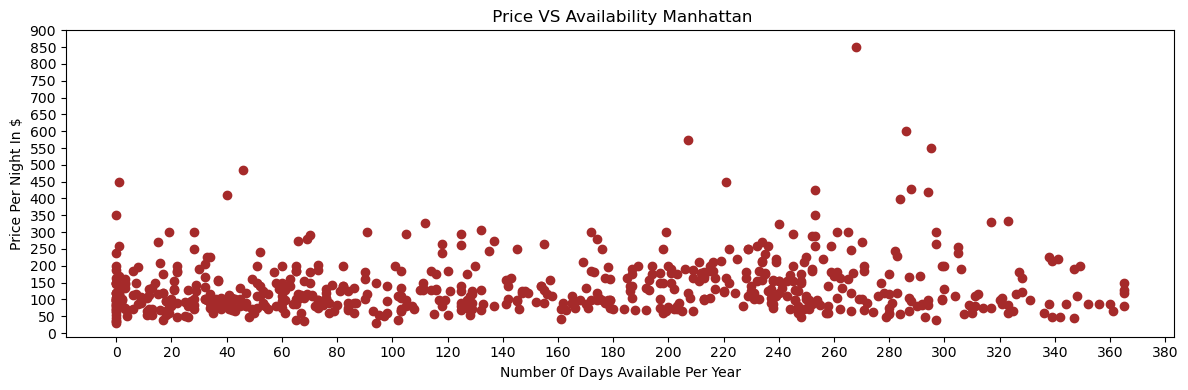

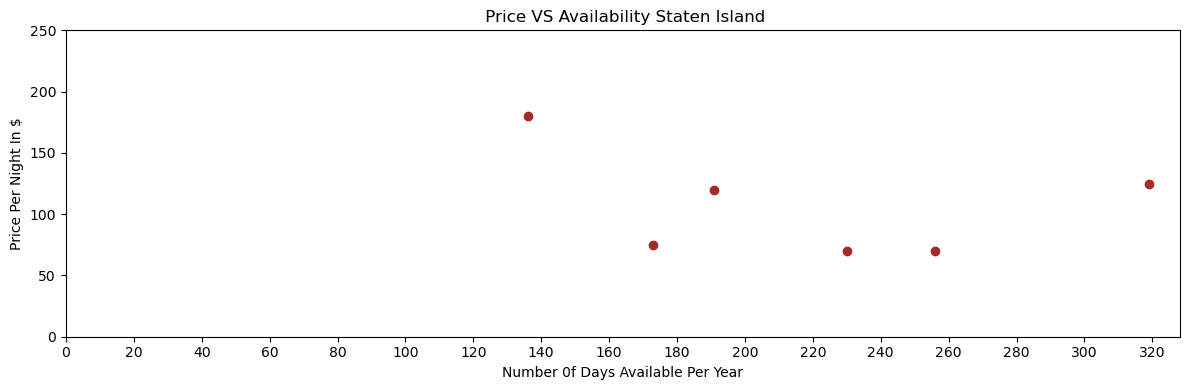

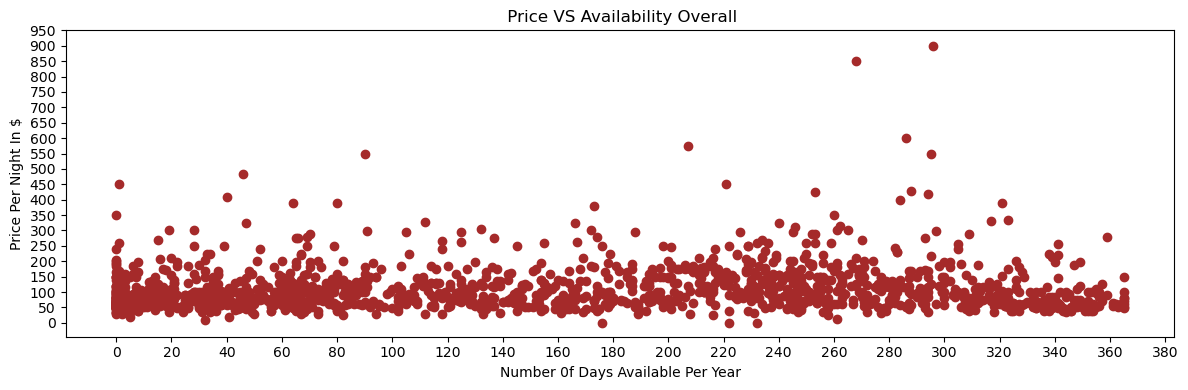

In [12]:

def make_scatter_price_availability(df, name_str):
    fig, axs = plt.subplots(figsize = (12,4))
    axs.scatter(df["availability_365"], df["price"], color="brown")
    axs.set_xlabel('Number 0f Days Available Per Year')
    axs.set_ylabel('Price Per Night In $')
    axs.set_yticks(range(0, df["price"].max()+100, 50))
    axs.set_xticks(range(0, df["availability_365"].max()+20, 20))
    axs.set_title(f" Price VS Availability {name_str}")
    plt.tight_layout()
    plt.show()

make_scatter_price_availability(top_performers_bronx, "Bronx")
make_scatter_price_availability(top_performers_brooklyn, "Brooklyn")
make_scatter_price_availability(top_performers_queens, "Queens")
make_scatter_price_availability(top_performers_manhattan, "Manhattan")
make_scatter_price_availability(top_performers_staten_island, "Staten Island")
make_scatter_price_availability(top_performers_overall, "Overall")

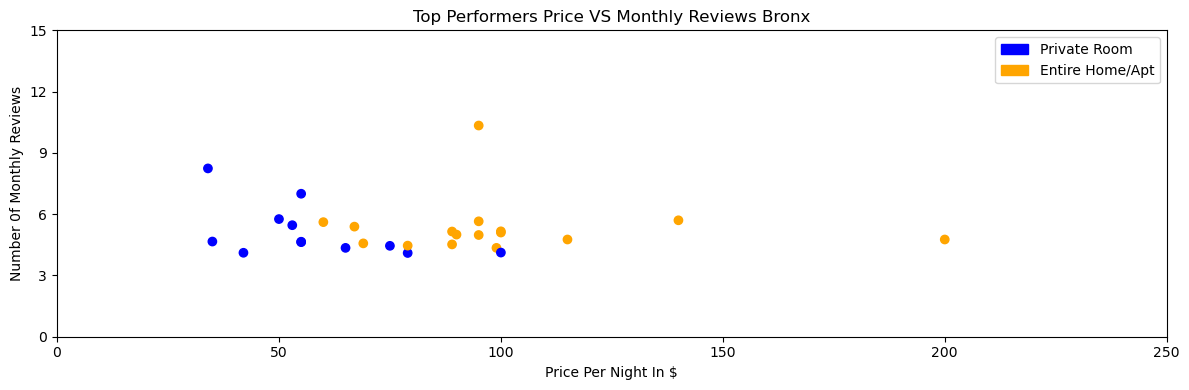

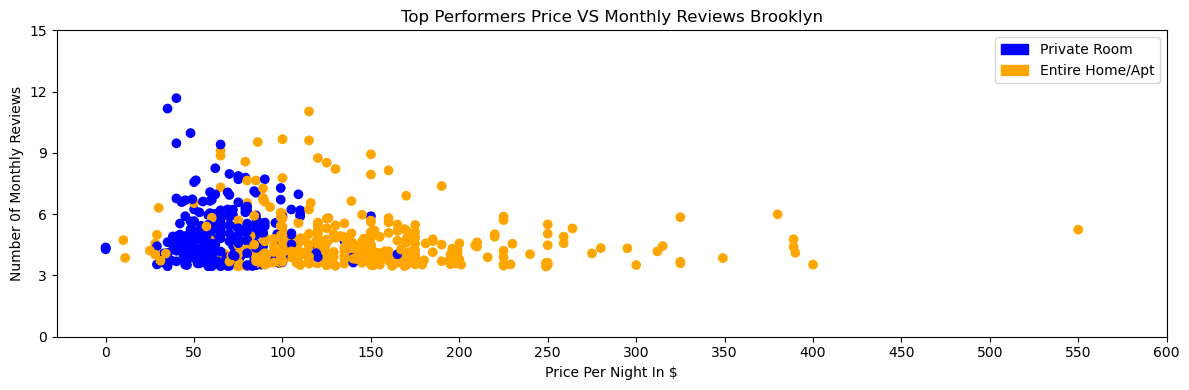

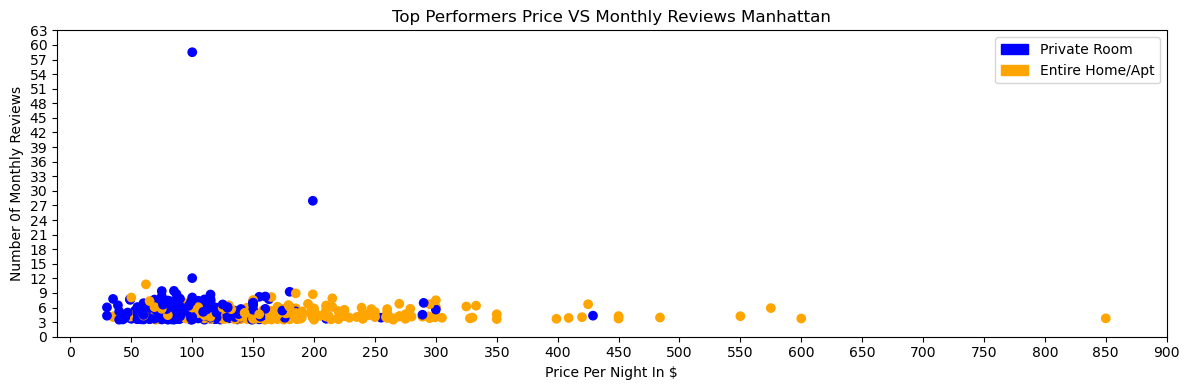

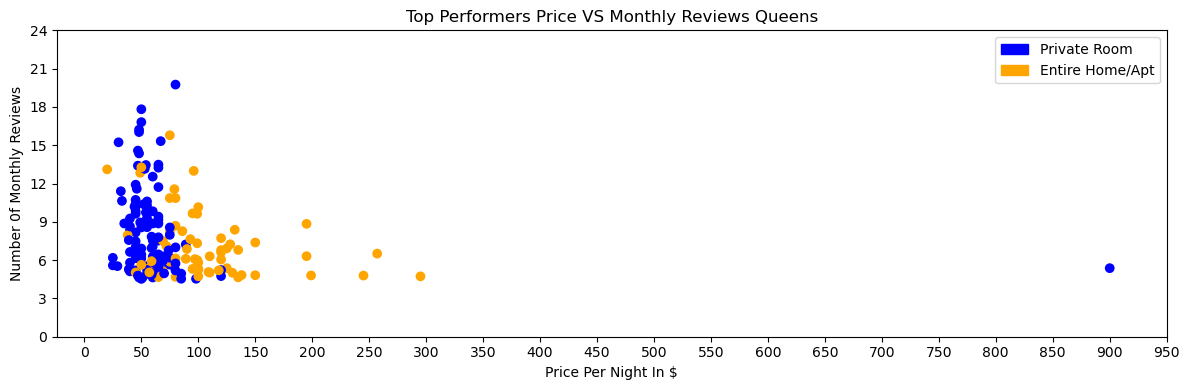

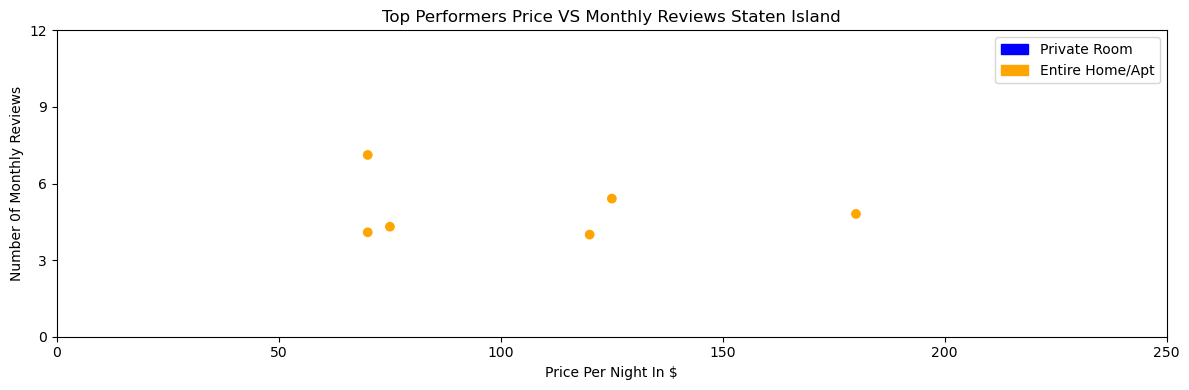

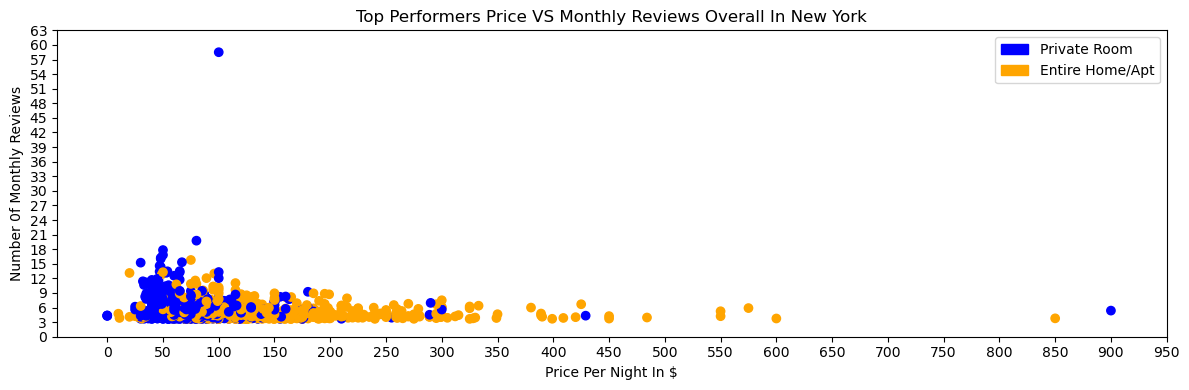

In [13]:
def make_scatter_reviews_per_month_price(df, name_str):
    #Seperate Colors based on room type
    color_array = np.where(df["room_type"] == "Private room", "blue", "orange")
    
    #Create multiple legend bars that correspond to the colors of the bar
    blue_patch = mpatches.Patch(color='blue', label='Private Room')
    orange_patch = mpatches.Patch(color='orange', label='Entire Home/Apt')
    
    fig, axs = plt.subplots(figsize = (12,4))
    axs.scatter(df["price"], df["reviews_per_month"], color=color_array)
    axs.set_xlabel('Price Per Night In $')
    axs.set_ylabel('Number 0f Monthly Reviews')
    axs.set_xticks(range(0, df["price"].max()+100, 50))
    axs.set_yticks(range(0, int(df["reviews_per_month"].max())+6, 3))
    axs.set_title(f"Top Performers Price VS Monthly Reviews {name_str}")
    plt.legend(handles=[blue_patch, orange_patch])
    plt.tight_layout()
    plt.show()

make_scatter_reviews_per_month_price(top_performers_bronx, "Bronx")
make_scatter_reviews_per_month_price(top_performers_brooklyn, "Brooklyn")
make_scatter_reviews_per_month_price(top_performers_manhattan, "Manhattan")
make_scatter_reviews_per_month_price(top_performers_queens, "Queens")
make_scatter_reviews_per_month_price(top_performers_staten_island, "Staten Island")
make_scatter_reviews_per_month_price(top_performers_overall, "Overall In New York")



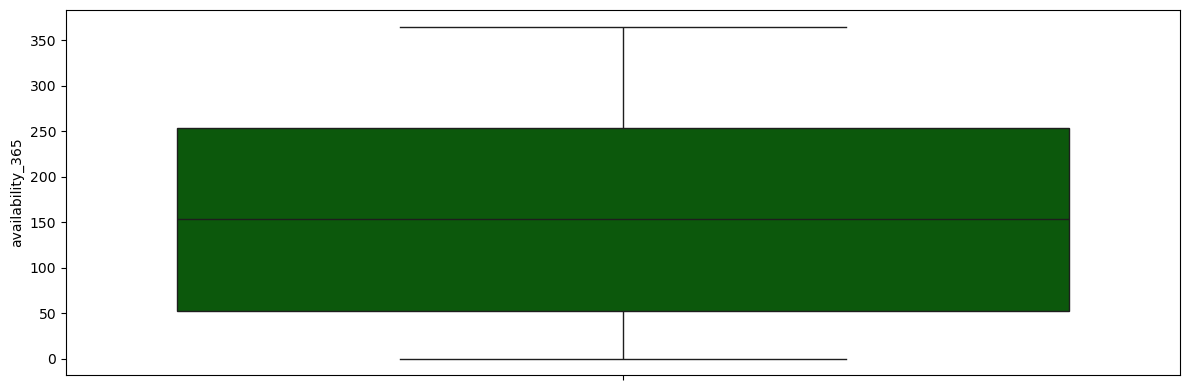

In [14]:
def make_box_plot(df, name_str):
    fig, axs = plt.subplots(figsize = (12,4))
    sns.boxplot(df["availability_365"], color="darkgreen")
    plt.tight_layout()
    plt.show()

make_box_plot(top_performers_overall, "Overall")

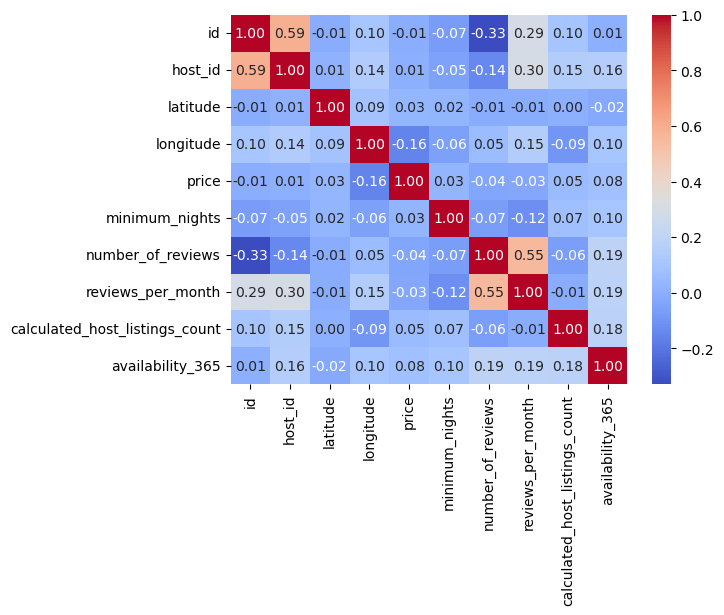

In [15]:

sns.heatmap(airbnb_df.corr(numeric_only = True), fmt=".2f", annot = True, cmap ="coolwarm")
plt.show()



In [16]:
# Create a map centered in New York
m = folium.Map(location=[40.7306, -73.9352], zoom_start=12)

#latitude, longitude
top_group = folium.FeatureGroup(name="Top Performers")
ntp_group = folium.FeatureGroup(name="Non Top Performers")

for index, row in top_performers_bronx.iterrows():
    location = [row['latitude'], row['longitude']]
    popup_text = f"""Top Performers: {row['neighbourhood_group']} 
    Number Of Reviews: {row['number_of_reviews']} 
    Reviews Per Month: {row['reviews_per_month']}
    Listing {row["listing"]}""" 

    folium.Marker(
        location=location,
        popup=folium.Popup(popup_text, min_width=300, max_width=500),
        icon=folium.Icon(color='green', icon='home') # Custom icon/color
    ).add_to(top_group)

for index, row in non_tp_bronx.iterrows():
    location = [row['latitude'], row['longitude']]
    popup_text = f"""Non Top Performers: {row['neighbourhood_group']}
    Number Of Reviews: {row['number_of_reviews']} 
    Reviews Per Month: {row['reviews_per_month']}
    Listing {row["listing"]}"""

    folium.Marker(
        location=location,
        popup=folium.Popup(popup_text, min_width=300, max_width=500),
        icon=folium.Icon(color='red', alpha=.02, icon='home') # Custom icon/color
    ).add_to(ntp_group)

top_group.add_to(m)
ntp_group.add_to(m)

folium.LayerControl().add_to(m)

m.save('../output/ny_top_performers_bronx.html')



#m

In [17]:
def make_ny_folium_map(ntp_df, tp_df, name_str):
    # Create a map centered in New York
    m = folium.Map(location=[40.7306, -73.9352], zoom_start=12)

    #latitude, longitude
    top_group = folium.FeatureGroup(name="Top Performers")
    ntp_group = folium.FeatureGroup(name="Non Top Performers")

    for index, row in tp_df.iterrows():
        location = [row['latitude'], row['longitude']]
        popup_text = f"""Top Performing AirBnB In {row['neighbourhood_group']} --->
        Number Of Reviews: {row['number_of_reviews']}, 
        Reviews Per Month: {row['reviews_per_month']}, 
        Price: ${row['price']} Per Night, 
        Listing {row["listing"]}"""


        folium.Marker(
            location=location,
            popup=folium.Popup(popup_text, min_width=300, max_width=500),
            icon=folium.Icon(color='green', icon='home') # Custom icon/color
            ).add_to(top_group)

    for index, row in ntp_df.iterrows():
        location = [row['latitude'], row['longitude']]
        popup_text = f"""Standard {row['neighbourhood_group']} AirBnB --->
        Number Of Reviews: {row['number_of_reviews']}, 
        Reviews Per Month: {row['reviews_per_month']},
        Price: ${row['price']} Per Night,
        Listing {row["listing"]}"""

        folium.Marker(
            location=location,
            popup=folium.Popup(popup_text, min_width=300, max_width=500),
            icon=folium.Icon(color='red', alpha=.02, icon='home') # Custom icon/color
        ).add_to(ntp_group)

    top_group.add_to(m)
    ntp_group.add_to(m)

    folium.LayerControl().add_to(m)
    # Custom HTML for the legend
    legend_html = """
    <div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: 100px;                
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; opacity:0.9;">
      &nbsp; <b>Legend</b> <br>
      &nbsp; <i class="fa fa-home fa-lg" style="color:red;"></i>&nbsp; Standard <br>
      &nbsp; <i class="fa fa-home fa-lg" style="color:green;"></i>&nbsp; Top Performers <br>
    </div>
    """

    m.get_root().html.add_child(folium.Element(legend_html))

    filename = '../output/ny_top_performers_' + name_str +'.html'
    m.save(filename)

make_ny_folium_map(non_tp_bronx, top_performers_bronx, "Bronx")
#make_ny_folium_map(non_tp_staten_island, top_performers_staten_island, "Staten Island")

In [18]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38843 entries, 0 to 48852
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38843 non-null  int64  
 1   listing                         38843 non-null  object 
 2   host_id                         38843 non-null  int64  
 3   host_name                       38843 non-null  object 
 4   neighbourhood_group             38843 non-null  object 
 5   neighbourhood                   38843 non-null  object 
 6   latitude                        38843 non-null  float64
 7   longitude                       38843 non-null  float64
 8   room_type                       38843 non-null  object 
 9   price                           38843 non-null  int64  
 10  minimum_nights                  38843 non-null  int64  
 11  number_of_reviews               38843 non-null  int64  
 12  last_review                     38843